In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import os 
import seaborn as sns
import glob
import natsort

In [2]:
import seaborn as sns
import copy

def load_data(save_path):
    datas = list()
    path_list = glob.glob(save_path)
    path_list = natsort.natsorted(path_list)
    data_temp = get_concat_glob(path_list)
    data_temp["a1"] = data_temp["a1"] * 100
    data_temp["a3"] = data_temp["a3"] * 100
    data_temp['Distribution'] = data_temp['distribution'] .map({0: "IID Label Distribution", 
                                                                0.3: "Non-IID Label Distribution",
                                                                0.5: "Non-IID Label Distribution"})
    return data_temp

In [3]:
def get_concat_glob(paths):
    data_ = []
    for i, path in enumerate(paths):


        # =====================================
        if "GGU" in path: continue
        if "GU211" in path: continue

        # if "EP10" not in path: continue
        # =====================================

       
        data = pd.read_csv(path)
        data["Mode"] = data["mode"]
        data["Scaling"] = "Vanilla"
        data["GU_ratio"] = 0
        data["n_epochs"] = 5

        if "_GU111.02" in path and "C100" in path: 
            data["Scaling"] = "GU111"
        elif "_GU112.02" in path and "C100" in path: 
            data["Scaling"] = "GU112"
        elif "_GU111.02" in path and "C10" in path: 
            data["Scaling"] = "GU111"
        elif "_GU112.02" in path and "C10" in path: 
            data["Scaling"] = "GU112"
        elif "_GU311" in path: 
            data["Scaling"] = "GU311"
        elif "_GU312" in path: 
            data["Scaling"] = "GU312"
        elif "_GU1" in path:
            continue
        elif "_GU2" in path:
            continue

        if "EP10" in path: data["n_epochs"] = 10
        
        if len(data_) == 0: data_ = data
        else: data_ = pd.concat([data_, data])
    return data_

## BarPlot

In [4]:
data_c100 = load_data("../Output_GU_C100/CIFAR100-*-N100-*/s[1-9].csv")   
data_c10  = load_data("../Output_GU_C10_M9/CIFAR10-*-N100-*/s[1-9].csv")

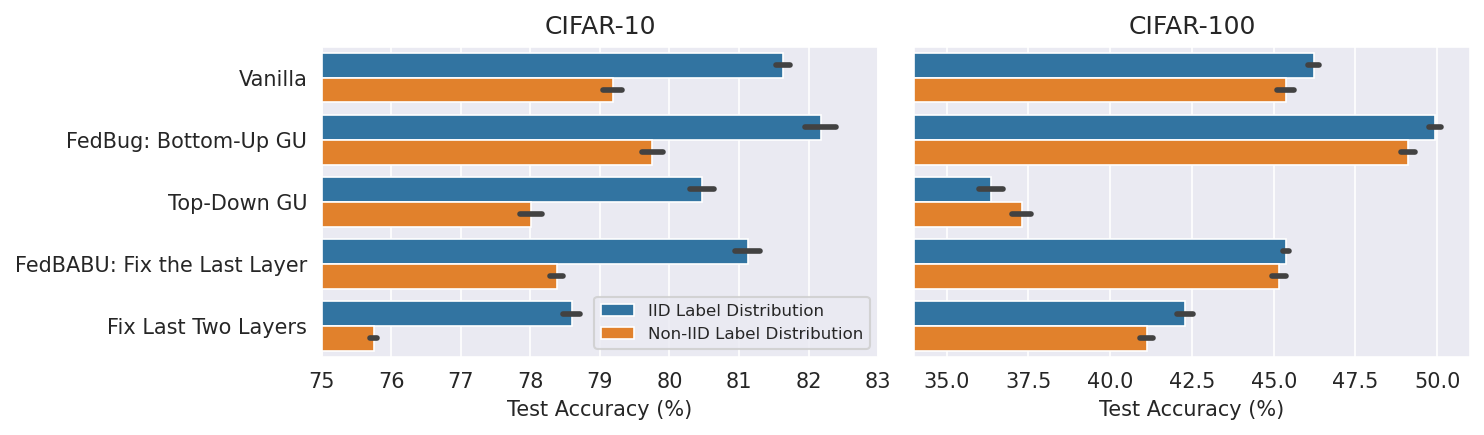

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=150, sharey=True)
sns.set_style("darkgrid")
for index, task, data_temp, title  in zip(range(2), ["Cifar10", "Cifar100"], [data_c10, data_c100], ["CIFAR-10", "CIFAR-100"]):
    ax = axes[index]
    temp = copy.deepcopy(data_temp)
    temp = temp[temp["act_prob"] == 0.01]
    if index == 0: temp = temp[temp["n_epochs"] == 10]
    elif index in [1,2]: temp = temp[temp["n_epochs"] == 5]
    if   index in [0]: temp = temp[(temp["epoch"] == 599)]
    elif index in [1]: temp = temp[(temp["epoch"] == 599)]

    replace_icon = {
        "GU111": "FedBug: Bottom-Up GU",
        "GU112": "Top-Down GU",
        "GU311": "FedBABU: Fix the Last Layer",
        "GU312": "Fix Last Two Layers",
    }
    sk = ["Vanilla"] + list(replace_icon.keys())
    temp = temp.set_index('Scaling').loc[sk].reset_index().replace({"Scaling": replace_icon})
    
    temp = temp[(temp["mode"] == "fedavg")]
    ax = sns.barplot(data=temp, x="a3", y="Scaling", hue="Distribution", ax=ax, errorbar="se", linewidth = 0.8)
    ax.set_title(title)

axes[0].set_xlabel("Test Accuracy (%)"), axes[1].set_xlabel("Test Accuracy (%)")
axes[0].set_xlim([75,83]), axes[1].set_xlim([34,51])
axes[0].legend(loc=4, prop={'size': 8}), axes[1].get_legend().remove()
axes[0].tick_params(axis='y', which='minor', pad=5)

for ax in axes.flatten(): ax.set_ylabel("")
fig.tight_layout() 
plt.savefig("../SaveFig/exp_ablation_fixation.pdf")
plt.pause(0.1)